# Solving nonlinear diffusion equation using SWIM-ODE

In [19]:
# Imports
import sys
sys.path.append('../../')
sys.path.append('../../src')
from sklearn.preprocessing import MinMaxScaler
from swimpde import Domain
from swimpde import BasicAnsatz
from swimpde import Nonlinear_Diffusion_Solver
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import matplotlib.cm as cm
np.random.seed(2)
import time
cmap = cm.jet
from examples import utils

### Load point cloud data

In [20]:
# Read and scale data
scaler = MinMaxScaler(feature_range=(0.65, 0.9))
# Load and preprocess training data
data_boundary = np.load('../../data/nature_inspired_dataset/nature_inspired_boundary_1000.npy')
data_interior = np.load('../../data/nature_inspired_dataset/nature_inspired_interior_1000.npy')
data_full = np.vstack((data_boundary, data_interior))
data_new = scaler.fit_transform(data_full) 
data_boundary = data_new[:np.shape(data_boundary)[0], :]
data_interior = data_new[np.shape(data_boundary)[0]::, :]

# Load and preprocess test data
data_eval = np.load('../../data/nature_inspired_dataset/nature_inspired_eval.npy')
x_eval = scaler.fit_transform(data_eval)

### Problem setup

In [21]:
import math
# initial condition
def u0(x):
    return np.sin(np.pi * x[:, 0]) * x[:, 1]**-3  

# forcing
def forcing(x, t):    
    return np.exp(-t) * np.sin(np.pi * x[:, 0]) * x[:, 1]**(-3) * (-1. - (-1) * np.exp(-t) * x[:, 1]**(-5) * np.sin(np.pi*x[:, 0]) * (-12 + np.pi**2 * x[:, 1]**2) )

# boundary condition
boundary_condition = "dirichlet"

# Analytical solution
def analytical_sol(x, t):
    return np.exp(-t) * np.sin(np.pi * x[:, 0]) * x[:, 1]**-3  
    
# Test data
t_eval = np.linspace(0, 1, 100).reshape(-1, 1, 1) # time domain
x_train = data_interior # space domain
u_true =  analytical_sol(x_eval, t_eval)
u_true = np.reshape(u_true, (np.shape(u_true)[0], np.shape(u_true)[2]))

### Visualize ground truth

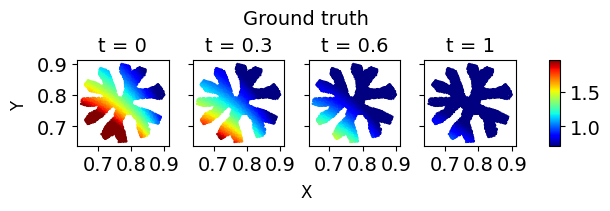

In [22]:
# Visualize the true solution
timesteps = [0, 30, 60, 99]
utils.plot(x=x_eval, u=u_true, timesteps=timesteps, 
           title='Ground truth', cmap_offset=0,
           savefig=True,figname='ground_truth.png')

### Fit and evaluate SWIM-ODE for good hyper-parameters 

In [23]:
seeds = [1, 2, 3]
experiments = []
width = 500 # Width
reg_const = 1e-15 # Regularization constant
svd_cutoff = 1e-15
rtol = 1e-6
atol = 1e-6
# Loop over different seeds
rmse_swim = np.ones((len(seeds), ))
rel_err_swim = np.ones((len(seeds), ))
time_swim = np.ones((len(seeds), ))
j = 0
info = []
for seed in seeds:
    ansatz_swim = BasicAnsatz(
        n_neurons=width,
        activation="tanh",
        random_state=seed,
        regularization_scale=reg_const,
        parameter_sampler = "tanh" 
    )   
    # Interior points
    normal_vectors = data_boundary.copy()
    # Domain
    domain = Domain(
        interior_points=data_interior,
        boundary_points=data_boundary,
        normal_vectors=normal_vectors
    )
    
    nonlinear_diffusion_solver_swim = Nonlinear_Diffusion_Solver(
        domain=domain, 
        ansatz=ansatz_swim,
        u0=u0,
        boundary_condition=boundary_condition,
        forcing=forcing,
        regularization_scale=reg_const,
        scale_boundary_correction=1.,
        boundary_condition_true=analytical_sol
    )
    # Compute weights and biases of the SWIM network
    time_blocks = 1
    ic_eval = u0(domain.interior_points)
    t_swim_start = time.time()
    sol_swim, solver_status_swim = nonlinear_diffusion_solver_swim.fit(t_span=[0, np.max(t_eval)], 
                                            rtol = rtol, atol = atol, svd_cutoff= svd_cutoff,
                                            outer_basis=False,
                                            init_cond=ic_eval);
    t_swim_stop = time.time()
    time_swim[j] = t_swim_stop - t_swim_start

    # Evaluate on test data
    u_swim_test = nonlinear_diffusion_solver_swim.evaluate(x_eval=x_eval, t_eval = t_eval).T #, solver_status=solver_status
                
    # Compute metrics
    rmse_swim[j] = np.sqrt(mean_squared_error(u_true, u_swim_test))  # mean squared error
    rel_err_swim[j] = rmse_swim[j]/np.sqrt(mean_squared_error(u_true, np.zeros_like(u_true)))

    # Compute metrics
    rmse_swim[j] = np.sqrt(mean_squared_error(u_true, u_swim_test))
    rel_err_swim[j] = rmse_swim[j]/np.sqrt(mean_squared_error(u_true, np.zeros_like(u_true)))
    info.append(time_swim[j])
    info.append(rmse_swim[j])
    print('time=', time_swim[j], 'rmse_elm=', rmse_swim[j], 'rel_err_elm=',rel_err_swim[j])
    j += 1

print('swim-ode time = ', np.mean(time_swim))
print('rmse swim-ode = ',np.mean(rmse_swim), '+-', np.std(rmse_swim))
print('rel l-2 error swim-ode = ',np.mean(rel_err_swim), '+-', np.std(rel_err_swim))
experiments.append(info)


time= 624.669686794281 rmse_elm= 8.923380206058717e-07 rel_err_elm= 9.116003200248746e-07
time= 349.9982464313507 rmse_elm= 2.960756217997641e-07 rel_err_elm= 3.0246680669391696e-07
time= 297.02810740470886 rmse_elm= 4.7091835376710395e-06 rel_err_elm= 4.810837508730201e-06
swim-ode time =  423.8986802101135
rmse swim-ode =  1.965865726692225e-06 +- 1.9550322539679832e-06
rel l-2 error swim-ode =  2.0083015451496643e-06 +- 1.997234217551436e-06


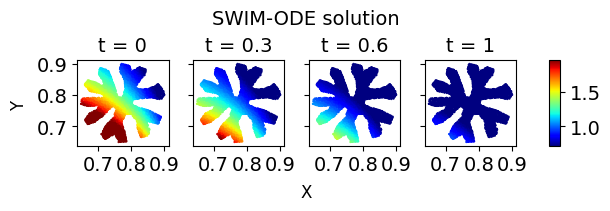

In [24]:
# Plot the ELM-ODE solution
utils.plot(x=x_eval, u=u_swim_test, timesteps=timesteps, title='SWIM-ODE solution',cmap_offset=0.)

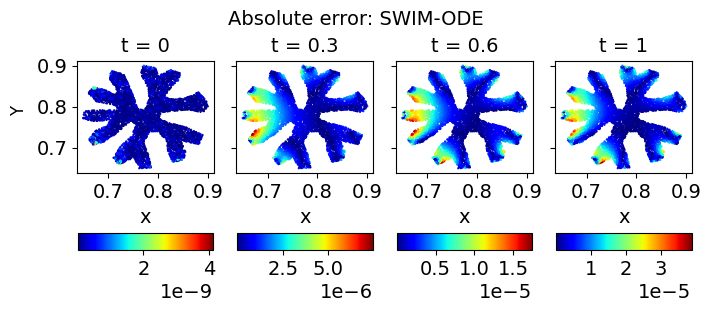

In [25]:
# Plot the absolute error with SWIM-ODE
utils.plot_error(x=x_eval, u_true=u_true, u_nn=u_swim_test, timesteps=timesteps, 
           figsize=(7,3), fontsize=14, 
           title='Absolute error: SWIM-ODE',savefig=True, 
           figname='swim_ode_error.png')